# Problem statement

Given a (directed) graph, we want to find all the colourings of the vertices in Red and Blue, such that Red is never connected to Red (but Blue can be anywhere).

My approach is to think about this in a graph theory way first, before cracking out the code.  We want to find all subsets of vertices such that no pair of vertices in a set are adjacent.  This should hopefully make us recall the notion of a
[clique](https://en.wikipedia.org/wiki/Clique_(graph_theory%29) which is the opposite: a subset of vertices where all pairs of vertices are adjacent.

So my approach is to:
- construct the "complement graph" (same vertices, an edge if and only if there was _not_ an edge in the original graph);
- use `networkx` to find all the cliques;
- finish by finding all subsets of the cliques.

Note that the general problem of finding all cliques is NP complete, so let's give up now on worrying about efficiency...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,0), (0,4), (4,6)])

Having updated my Anaconda install, I can now draw it...

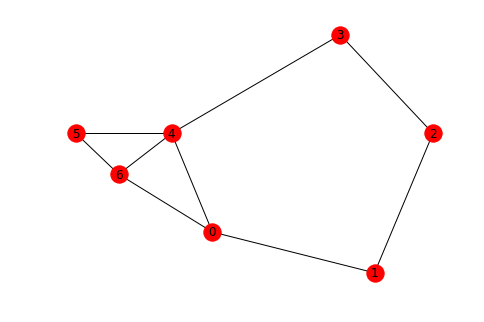

In [3]:
nx.draw_spectral(G, with_labels=True)

Firstly find the complement graph, in a lazy, loop over all edges way.

In [4]:
CG = nx.Graph()
for i in G.nodes():
    for j in G.nodes():
        if i != j and i not in G[j]:
            CG.add_edge(i, j)

In [5]:
list( nx.find_cliques(CG) )

[[0, 5, 2], [0, 5, 3], [1, 3, 5], [1, 3, 6], [1, 4], [2, 4], [2, 6]]

For the final part, we will want to find all subsets of these sets.  That is, find the powersets.  The following seems a fairly nice way to do this, using the Python standard library.

In [6]:
from itertools import combinations

def powerset(x):
    for i in range(1, len(x)+1):
        yield from combinations(x, i)
        
# Quick test!
assert set(powerset({1,2,3})) == {(1,), (2,), (3,), (1,2), (1,3), (2,3), (1,2,3)}

In [7]:
red_vertices = set()
for clique in nx.find_cliques(CG):
    for subset in powerset(clique):
        red_vertices.add(subset)

red_vertices

{(0,),
 (0, 2),
 (0, 3),
 (0, 5),
 (0, 5, 2),
 (0, 5, 3),
 (1,),
 (1, 3),
 (1, 3, 5),
 (1, 3, 6),
 (1, 4),
 (1, 5),
 (1, 6),
 (2,),
 (2, 4),
 (2, 6),
 (3,),
 (3, 5),
 (3, 6),
 (4,),
 (5,),
 (5, 2),
 (5, 3),
 (6,)}

# 2nd part

We now make a new directed graph, where:
- the nodes are the sets we found above.  Rob calls these "patterns".
- An edge is allowed to join pattern X to pattern Y if we can get from X to Y by:
   - Adding one new node to X, say u.  u must not be a successor of any vertex in X
   - if u->v is in our original directed graph, then delete v
   
I don't really see a "neat" way to do this, so let's attack it in a brute force way.

In [8]:
G = nx.DiGraph([(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,0), (0,4), (4,6)])

It is possible that I have the directions of the edges linking (0,4) and (4,6) wrong.

In [9]:
def allowed_mutations(G, subset):
    """Yield mutated subsets.  Each mutation follows the rules:
      - Add a single vertex v
      - Delete any vertices are _successors_ of v
    
    :param G: The directed graph.
    :param subset: The subset of vertices to mutate.
    """
    for v in G.nodes():
        if v not in subset and len(set(G.predecessors(v)) & subset) == 0:
            new_subset = set(subset)
            new_subset.add(v)
            new_subset.difference_update(G.successors(v))
            yield new_subset
            
list(allowed_mutations(G, {0}))

[{0, 2}, {0, 3}, {0, 5}, {6}]

In [10]:
list(allowed_mutations(G, {3, 6}))

[{1, 3, 6}, {2, 6}, {3, 5}]

In [11]:
list(allowed_mutations(G, {0, 2, 5}))

[]

In [12]:
state_graph = nx.DiGraph()
nodes = {frozenset(s) for s in red_vertices}

for node in nodes:
    for end in allowed_mutations(G, node):
        end = frozenset(end)
        if end in nodes:
            state_graph.add_edge(node, end)

In [13]:
for node in state_graph.nodes():
    nodes = state_graph[node]
    print(tuple(node), "-->", [tuple(x) for x in nodes])

(3, 6) --> [(1, 3, 6), (2, 6), (3, 5)]
(1, 3, 6) --> [(1, 3, 5)]
(2, 6) --> [(1, 6), (2, 4), (2, 5)]
(3, 5) --> [(0, 3, 5), (1, 3, 5), (2, 5)]
(1, 5) --> [(0, 5), (1, 3, 5), (1, 4)]
(0, 5) --> [(0, 2, 5), (0, 3, 5)]
(1, 3, 5) --> [(0, 3, 5)]
(1, 4) --> [(0,), (1, 3)]
(1, 6) --> [(1, 3, 6), (1, 4), (1, 5)]
(2, 4) --> [(0, 2), (1, 4)]
(2, 5) --> [(0, 2, 5), (1, 5), (2, 4)]
(0, 3, 5) --> [(0, 2, 5)]
(0, 2, 5) --> []
(5,) --> [(0, 5), (1, 5), (2, 5), (3, 5), (4,)]
(4,) --> [(0,), (1, 4), (2, 4), (3,)]
(3,) --> [(0, 3), (1, 3), (2,), (3, 5), (3, 6)]
(0, 3) --> [(0, 2), (0, 3, 5), (3, 6)]
(1, 3) --> [(0, 3), (1, 3, 5), (1, 3, 6)]
(2,) --> [(0, 2), (1,), (2, 4), (2, 5), (2, 6)]
(0,) --> [(0, 2), (0, 3), (0, 5), (6,)]
(0, 2) --> [(0, 2, 5), (2, 6)]
(6,) --> [(1, 6), (2, 6), (3, 6), (4,), (5,)]
(1,) --> [(0,), (1, 3), (1, 4), (1, 5), (1, 6)]


I _think_ this now works right, at least according to the specification I gave above.  The specification could be wrong.

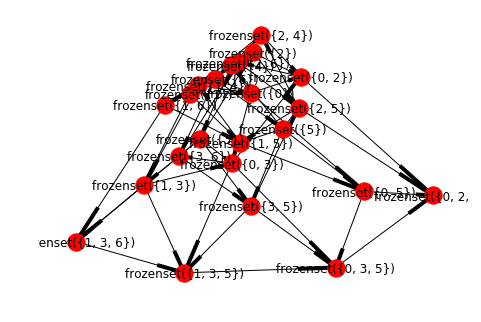

In [14]:
nx.draw_spectral(state_graph, with_labels=True)

### Next steps

- Factor all the code into functions
- Move to a Python package
- Add some unit tests.

# Original Motivation

The original motivation is a dynamical system on the original directed graph.
- States are assignments of "on" (red) and "off" (blue) to the nodes, with the rule that if u->v is in the graph, then you cannot have both u and v "on"
- Transitions are basically the rule above: turn "on" one extra node u, and then turn "off" any nodes which u points to.  Nodes which are "on" "suppress" the ability of a node to turn on.